In [11]:
import functools
import os
import pickle

In [15]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import ndimage, stats

In [3]:
import lib

In [4]:
def watermark(
    fig,
    text="preliminary",
):
    fig_width, fig_height = fig.get_size_inches()
    angle = np.degrees(np.arctan2(fig_height, fig_width))
    size = np.hypot(fig_width, fig_height) * 6 
    fig.text(
        0.5,
        0.5,
        text,
        color="k",
        alpha=0.1,
        fontsize=size,
        rotation=angle,
        horizontalalignment="center",
        verticalalignment="center",
    )

    return None

In [12]:
gal_weight_file = "/pscratch/sd/m/myamamot/des-y6-analysis/y6_measurement/v6_UNBLINDED/inverse_variance_weight_v6.pickle"

In [13]:
with open(gal_weight_file, 'rb') as handle:
    wgt_dict = pickle.load(handle)

In [17]:
xedges = wgt_dict['xedges']  # S/N
yedges = wgt_dict['yedges']  # T/Tpsf
smooth_response = ndimage.gaussian_filter(wgt_dict['response'], sigma=2.0)

In [47]:
size_ratio_bins = yedges
snr_bins = xedges

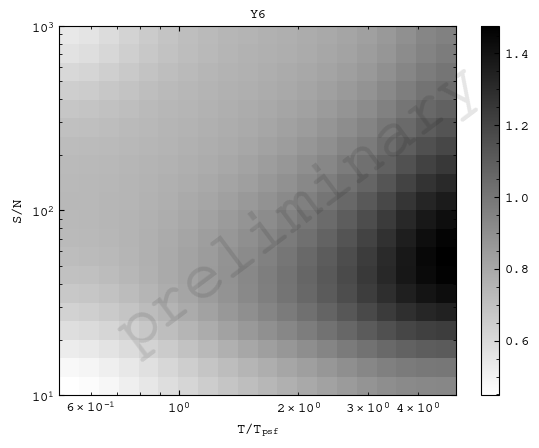

In [140]:
fig, axs = plt.subplots(1, 1)

m = axs.pcolormesh(
    size_ratio_bins,
    snr_bins,
    smooth_response,
)

axs.set_xscale("log")
axs.set_yscale("log")

axs.set_xlabel("$T/T_{psf}$")
axs.set_ylabel("$S/N$")
axs.set_title("Y6")

plt.colorbar(m)

watermark(fig)

plt.show()

In [135]:
def _get_response_grid(shear_step, snr_bins, size_ratio_bins):
    shear_sim = h5py.File(lib.const.SIM_SHEAR_CATALOGS[shear_step])

    size_ratio_1p = shear_sim["mdet"]["1p"]["gauss_T_ratio"][:]
    snr_1p = shear_sim["mdet"]["1p"]["gauss_s2n"][:]
    g1_1p = shear_sim["mdet"]["1p"]["gauss_g_1"][:]
    w_1p = lib.weight.get_shear_weights(shear_sim["mdet"]["1p"])

    size_ratio_1m = shear_sim["mdet"]["1m"]["gauss_T_ratio"][:]
    snr_1m = shear_sim["mdet"]["1m"]["gauss_s2n"][:]
    g1_1m = shear_sim["mdet"]["1m"]["gauss_g_1"][:]
    w_1m = lib.weight.get_shear_weights(shear_sim["mdet"]["1m"])

    size_ratio_2p = shear_sim["mdet"]["2p"]["gauss_T_ratio"][:]
    snr_2p = shear_sim["mdet"]["2p"]["gauss_s2n"][:]
    g2_2p = shear_sim["mdet"]["2p"]["gauss_g_2"][:]
    w_2p = lib.weight.get_shear_weights(shear_sim["mdet"]["2p"])

    size_ratio_2m = shear_sim["mdet"]["2m"]["gauss_T_ratio"][:]
    snr_2m = shear_sim["mdet"]["2m"]["gauss_s2n"][:]
    g2_2m = shear_sim["mdet"]["2m"]["gauss_g_2"][:]
    w_2m = lib.weight.get_shear_weights(shear_sim["mdet"]["2m"])

    w_1p_grid, _, _, _ = stats.binned_statistic_2d(
        snr_1p,
        size_ratio_1p,
        w_1p,
        statistic="sum",
        bins=[snr_bins, size_ratio_bins],
    )
    _g1_1p_grid, _, _, _ = stats.binned_statistic_2d(
        snr_1p,
        size_ratio_1p,
        g1_1p * w_1p,
        statistic="sum",
        bins=[snr_bins, size_ratio_bins],
    )
    g1_1p_grid = _g1_1p_grid / w_1p_grid

    w_1m_grid, _, _, _ = stats.binned_statistic_2d(
        snr_1m,
        size_ratio_1m,
        w_1m,
        statistic="sum",
        bins=[snr_bins, size_ratio_bins],
    )
    _g1_1m_grid, _, _, _ = stats.binned_statistic_2d(
        snr_1m,
        size_ratio_1m,
        g1_1m * w_1m,
        statistic="sum",
        bins=[snr_bins, size_ratio_bins],
    )
    g1_1m_grid = _g1_1m_grid / w_1m_grid

    w_2p_grid, _, _, _ = stats.binned_statistic_2d(
        snr_2p,
        size_ratio_2p,
        w_2p,
        statistic="sum",
        bins=[snr_bins, size_ratio_bins],
    )
    _g2_2p_grid, _, _, _ = stats.binned_statistic_2d(
        snr_2p,
        size_ratio_2p,
        g2_2p * w_2p,
        statistic="sum",
        bins=[snr_bins, size_ratio_bins],
    )
    g2_2p_grid = _g2_2p_grid / w_2p_grid
    
    w_2m_grid, _, _, _ = stats.binned_statistic_2d(
        snr_2m,
        size_ratio_2m,
        w_2m,
        statistic="sum",
        bins=[snr_bins, size_ratio_bins],
    )
    _g2_2m_grid, _, _, _ = stats.binned_statistic_2d(
        snr_2m,
        size_ratio_2m,
        g2_2m * w_2m,
        statistic="sum",
        bins=[snr_bins, size_ratio_bins],
    )
    g2_2m_grid = _g2_2m_grid / w_2m_grid
    
    R_11_grid = (g1_1p_grid - g1_1m_grid) / (2 * 0.01)
    R_22_grid = (g2_2p_grid - g2_2m_grid) / (2 * 0.01)
    
    R_grid = 0.5 * (R_11_grid + R_22_grid)
    
    smooth_response_sim = ndimage.gaussian_filter(R_grid, sigma=2.0)

    return smooth_response_sim, snr_bins, size_ratio_bins

In [146]:
def get_response_grid(snr_bins, size_ratio_bins):
    shear_step_plus = "g1_slice=0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0"
    shear_step_minus = "g1_slice=-0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0"

    smooth_response_sim_p, _, _ = _get_response_grid(shear_step_plus, snr_bins, size_ratio_bins)
    smooth_response_sim_m, _, _ = _get_response_grid(shear_step_minus, snr_bins, size_ratio_bins)

    smooth_response_sim = 0.5 * (smooth_response_sim_p + smooth_response_sim_m)

    return smooth_response_sim, snr_bins, size_ratio_bins

In [139]:
smooth_response_sim, _, _ = get_response_grid(snr_bins, size_ratio_bins)

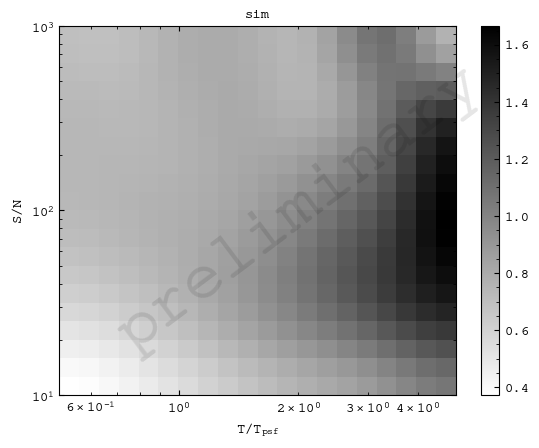

In [148]:
fig, axs = plt.subplots(1, 1)

m = axs.pcolormesh(
    size_ratio_bins,
    snr_bins,
    smooth_response_sim,
)

axs.set_xscale("log")
axs.set_yscale("log")

axs.set_xlabel("$T/T_{psf}$")
axs.set_ylabel("$S/N$")
axs.set_title("sim")

plt.colorbar(m)

watermark(fig)

plt.show()

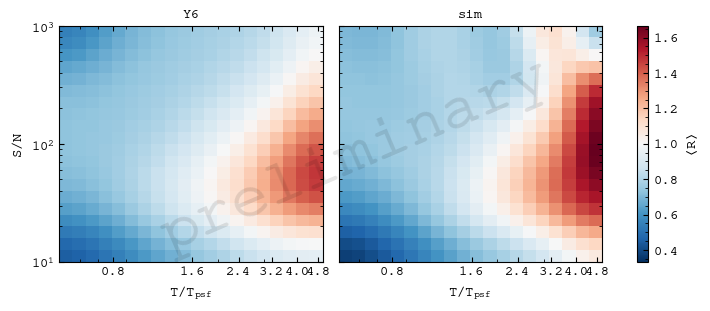

In [150]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3), sharex=True, sharey=True, constrained_layout=True)

norm = mpl.colors.CenteredNorm(1.0)
cmap = "RdBu_r"

axs[1].pcolormesh(
    size_ratio_bins,
    snr_bins,
    smooth_response_sim,
    norm=norm,
    cmap=cmap,
)
axs[0].pcolormesh(
    size_ratio_bins,
    snr_bins,
    smooth_response,
    norm=norm,
    cmap=cmap,
)

axs[0].set_xscale("log")
axs[0].set_yscale("log")

axs[0].xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
axs[0].xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
axs[0].xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins="auto"))

axs[0].set_xlabel("$T/T_{psf}$")
axs[1].set_xlabel("$T/T_{psf}$")
axs[0].set_ylabel("$S/N$")

axs[0].set_title("Y6")
axs[1].set_title("sim")

# plt.colorbar(m)
fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=axs.ravel().tolist(),
    label="$〈R〉$",
)

watermark(fig)

plt.show()